In [1]:
import os
from os import walk

import pandas as pd
idx = pd.IndexSlice

import numpy as np
import sys
import re
import json

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import seaborn as sns

from collections import Counter

%matplotlib inline

pd.set_option('display.max_rows', 9000)
pd.set_option('display.max_columns', 1500)
pd.set_option('max_colwidth', 400)

from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:70% !important; }</style>"))

#Set seaborn color palette:

palette_list = list(sns.color_palette("colorblind"))



# Load result dataframes

In [2]:
with open('result_data/results_full_dataset.json', 'r') as infile:
    results_dict = json.load(infile)


In [3]:

#Reformat json structure into pandas Dataframe
reformatted_dict = dict()
for resolution, tool_dict in results_dict.items():
    for tool, locus_dict in tool_dict.items():
        for locus, metric_dict in locus_dict.items():
            for metric, value in metric_dict.items():
                if (tool, resolution) not in reformatted_dict:
                    reformatted_dict[(tool, resolution)] = dict()

                #Drop count, score and save typing accuracy per resolution
                if metric == 'typing_accuracy':
                    reformatted_dict[(tool, resolution)][locus] = value
                elif (metric == 'call_rate'):
                    if (tool, metric) not in reformatted_dict:
                        reformatted_dict[(tool, metric)] = dict()
                    if locus not in reformatted_dict[(tool, metric)]:
                        reformatted_dict[(tool, metric)][locus] = value
    
results_df = pd.DataFrame(reformatted_dict)


tool_order = ['Kourami', 'HLA-LA', 'Optitype', 'Hisatgenotype', 'STC-seq']
metric_order = ['call_rate', '1-field', 'pseudosequence', 'P group', '2-field']

multi_tuples = []
for tool in tool_order:
    for metric in metric_order:
        multi_tuples += [(tool, metric)]

multi_cols = pd.MultiIndex.from_tuples(multi_tuples, names=['Tool', 'Metric'])

results_df = pd.DataFrame(results_df, columns=multi_cols)
results_df

Tool      Kourami                                                    HLA-LA  \
Metric  call_rate    1-field pseudosequence    P group    2-field call_rate   
A       96.501809  95.355850      88.661037  85.645356  85.645356     100.0   
B       86.369119  84.800965      79.131484  78.287093  78.287093     100.0   
C       90.470446  89.445115      84.439083  82.689988  82.026538     100.0   
DRB1    99.396864  97.346200      96.501809  96.381182  95.717732     100.0   
DQB1    83.715320  79.131484      76.176116  75.572979  73.944511     100.0   
HLA-I   91.113792  89.867310      84.077201  82.207479  81.986329     100.0   
HLA-II  91.556092  88.238842      86.338963  85.977081  84.831122     100.0   
Total   91.290712  89.215923      84.981906  83.715320  83.124246     100.0   

Tool                                                    Optitype             \
Metric    1-field pseudosequence    P group    2-field call_rate    1-field   
A       99.155609      95.054282  92.762364  92.762364     100.0  99.819059   
B       99.457177      98.130277  97.889023  97.768396     100.0  99.215923   
C       99.638118      97.828709  97.165259  96.622437     100.0  99.698432   
DRB1    98.431846      97.949337  97.889023  97.225573       0.0   0.000000   
DQB1    99.155609      97.104946  95.778046  94.028951       0.0   0.000000   
HLA-I   99.416968      97.004423  95.938882  95.717732     100.0  99.577805   
HLA-II  98.793727      97.527141  96.833534  95.627262       0.0   0.000000   
Total   99.167672      97.213510  96.296743  95.681544      60.0  59.746683   

Tool                                        Hisatgenotype             \
Metric pseudosequence    P group    2-field     call_rate    1-field   
A           99.034982  98.914355  98.914355         100.0  92.943305   
B           98.371532  98.130277  98.009650         100.0  97.828709   
C           99.396864  99.034982  98.492159         100.0  96.863691   
DRB1         0.000000   0.000000   0.000000         100.0  94.451146   
DQB1         0.000000   0.000000   0.000000         100.0  94.933655   
HLA-I       98.934459  98.693205  98.472055         100.0  95.878569   
HLA-II       0.000000   0.000000   0.000000         100.0  94.692400   
Total       59.360676  59.215923  59.083233         100.0  95.404101   

Tool                                           STC-seq             \
Metric pseudosequence    P group    2-field  call_rate    1-field   
A           87.092883  81.121834  81.001206  70.084439  60.313631   
B           94.089264  93.305187  93.063932  71.170084  57.961399   
C           94.813028  93.003619  92.822678  67.913148  58.624849   
DRB1        90.651387  88.600724  88.299156  77.201448  67.249698   
DQB1        92.460796  89.987937  88.902292  57.901086  52.171291   
HLA-I       91.998392  89.143546  88.962606  69.722557  58.966626   
HLA-II      91.556092  89.294331  88.600724  67.551267  59.710495   
Total       91.821472  89.203860  88.817853  68.854041  59.264174   

Tool                                         
Metric pseudosequence    P group    2-field  
A           54.402895  51.447527  50.844391  
B           48.190591  46.863691  46.381182  
C           50.180941  45.778046  44.511460  
DRB1        63.027744  62.786490  62.484922  
DQB1        49.758745  48.250905  47.225573  
HLA-I       50.924809  48.029755  47.245678  
HLA-II      56.393245  55.518697  54.855247  
Total       53.112183  51.025332  50.289505

In [4]:
results_df.to_csv('result_data/results_df_full_coverage.csv')

# Plots of the Performance of the tools

In [5]:
idx = pd.IndexSlice

labels1 = ['Kourami', 'HLA-LA', 'Hisatgenotype', 'STC-seq', 'Optitype']
labels2 = ['Kourami', 'HLA-LA', 'Hisatgenotype', 'STC-seq']
textlabels1 = ['Kourami', 'HLA*LA', 'HISAT-genotype', 'STC-Seq', 'Optitype']
textlabels2 = ['Kourami', 'HLA*LA', 'HISAT-genotype', 'STC-Seq', '']

def make_plot_from_allele_list():

    fig, axs = plt.subplot_mosaic([['A'], ['B']], constrained_layout=True, figsize=(18,12))
    figpanels = ['A', 'B']

    for label, ax in axs.items():

        if label == 'A':
            allele_index = 'HLA-I'
            title = 'HLA Class I alleles (HLA-A, -B and -C)'
        else:
            allele_index = 'HLA-II'
            title = 'HLA Class II alleles (HLA-DRB1 and -DQB1)'

        if allele_index in ('HLA-II', 'DRB1', 'DQB1'):
            call_rate = list(results_df.loc[allele_index, idx[labels1, 'call_rate']])
            accuracy_one_field = list(results_df.loc[allele_index, idx[labels1, '1-field']])
            accuracy_two_field = list(results_df.loc[allele_index, idx[labels1, '2-field']])
            accuracy_p_group = list(results_df.loc[allele_index, idx[labels1, 'P group']])
            accuracy_e_group = list(results_df.loc[allele_index, idx[labels1, 'pseudosequence']])
        
            x = np.arange(len(labels1))
            
        else:   
            call_rate = list(results_df.loc[allele_index, idx[labels1, 'call_rate']])
            accuracy_one_field = list(results_df.loc[allele_index, idx[labels1, '1-field']])
            accuracy_two_field = list(results_df.loc[allele_index, idx[labels1, '2-field']])
            accuracy_p_group = list(results_df.loc[allele_index, idx[labels1, 'P group']])
            accuracy_e_group = list(results_df.loc[allele_index, idx[labels1, 'pseudosequence']])
                
            x = np.arange(len(labels1))  # the label locations
    

        width = 0.18  # the width of the bars
        rects1 = ax.bar(x - 10*width/5, call_rate, width, label='call rate', color = '#808080')
        rects2 = ax.bar(x - 5*width/5, accuracy_one_field, width, label='1-field accuracy', color = palette_list[0])
        rects3 = ax.bar(x, accuracy_e_group, width, label='Pseudoseq accuracy', color = palette_list[1])
        rects4 = ax.bar(x + 5*width/5, accuracy_p_group, width, label='P group accuracy', color = palette_list[2])
        rects5 = ax.bar(x + 10*width/5, accuracy_two_field, width, label='2-field accuracy', color = palette_list[3])

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('%', size = 22)
        ax.set_xticks(x)
        
        if allele_index in ('HLA-II', 'DRB1', 'DQB1'):
            ax.set_xticklabels(textlabels2, size = 18)
        else:
            ax.set_xticklabels(textlabels1, size = 18)

        ax.legend()


        def autolabel(rects, y_height):
            """Attach a text label above each bar in *rects*, displaying its height."""
            for rect in rects:
                if (allele_index in ('HLA-II', 'DRB1', 'DQB1')) and (rect.get_x() > 3.5):
                    continue
                else:
                    height = rect.get_height()
                    ax.annotate('{:.1f}'.format(height, ),
                                xy=(rect.get_x() + rect.get_width() / 2, y_height),
                                xytext=(0, 3),  # 3 points vertical offset
                                textcoords="offset points",
                                ha='center', va='bottom', 
                                color="black", size = 16, weight =400)

        autolabel(rects1, 50)
        autolabel(rects2, 40)
        autolabel(rects3, 30)
        autolabel(rects4, 20)
        autolabel(rects5, 10)        
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)       
        
        ax.grid(which='minor', alpha=0.4)
        # Major ticks every 20, minor ticks every 5
        minor_ticks = np.arange(0, 101, 5)

        ax.set_yticks(minor_ticks, minor=True)
        ax.tick_params(axis="y", labelsize=16)


        # Or if you want different settings for the grids:
        ax.grid(axis = 'y')
        ax.set_axisbelow(True)

        if allele_index in ('HLA-II', 'DRB1', 'DQB1'):
            ax.legend(loc='right', prop={'size': 18})
        else:
            ax.get_legend().remove()
        plt.tight_layout()

        #plt.title('HLA typing performance for HLA-A, -B, -C, -DRB1 and DQB1', size = 24)
        #plt.title('HLA typing performance for HLA class II genes (with ensemble)', size = 24)
        ax.set_title(f'HLA typing performance for {title}', size = 22)
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(-0.01, 1.0, label, transform=ax.transAxes + trans,
                fontsize=22, va='bottom', fontfamily='serif', weight='bold')
    
    plt.tight_layout()
    
    return plt

## Overall Results

/tmp/ipykernel_1001358/1010325940.py:101: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


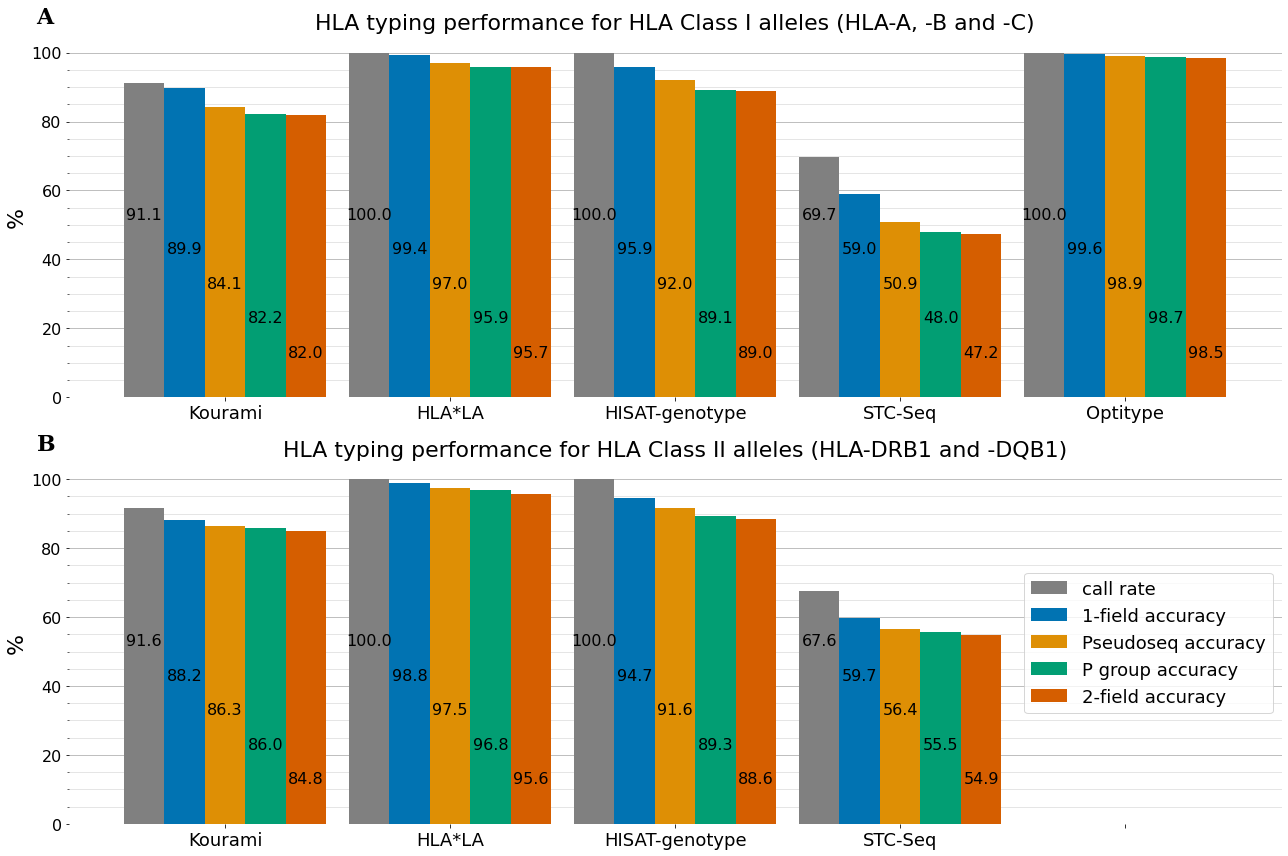

In [6]:
fig = make_plot_from_allele_list()
fig.savefig('paper_plots/Figure2.tiff')
fig.savefig('paper_plots/Figure2.eps')

In [7]:
results_df

Tool      Kourami                                                    HLA-LA  \
Metric  call_rate    1-field pseudosequence    P group    2-field call_rate   
A       96.501809  95.355850      88.661037  85.645356  85.645356     100.0   
B       86.369119  84.800965      79.131484  78.287093  78.287093     100.0   
C       90.470446  89.445115      84.439083  82.689988  82.026538     100.0   
DRB1    99.396864  97.346200      96.501809  96.381182  95.717732     100.0   
DQB1    83.715320  79.131484      76.176116  75.572979  73.944511     100.0   
HLA-I   91.113792  89.867310      84.077201  82.207479  81.986329     100.0   
HLA-II  91.556092  88.238842      86.338963  85.977081  84.831122     100.0   
Total   91.290712  89.215923      84.981906  83.715320  83.124246     100.0   

Tool                                                    Optitype             \
Metric    1-field pseudosequence    P group    2-field call_rate    1-field   
A       99.155609      95.054282  92.762364  92.762364     100.0  99.819059   
B       99.457177      98.130277  97.889023  97.768396     100.0  99.215923   
C       99.638118      97.828709  97.165259  96.622437     100.0  99.698432   
DRB1    98.431846      97.949337  97.889023  97.225573       0.0   0.000000   
DQB1    99.155609      97.104946  95.778046  94.028951       0.0   0.000000   
HLA-I   99.416968      97.004423  95.938882  95.717732     100.0  99.577805   
HLA-II  98.793727      97.527141  96.833534  95.627262       0.0   0.000000   
Total   99.167672      97.213510  96.296743  95.681544      60.0  59.746683   

Tool                                        Hisatgenotype             \
Metric pseudosequence    P group    2-field     call_rate    1-field   
A           99.034982  98.914355  98.914355         100.0  92.943305   
B           98.371532  98.130277  98.009650         100.0  97.828709   
C           99.396864  99.034982  98.492159         100.0  96.863691   
DRB1         0.000000   0.000000   0.000000         100.0  94.451146   
DQB1         0.000000   0.000000   0.000000         100.0  94.933655   
HLA-I       98.934459  98.693205  98.472055         100.0  95.878569   
HLA-II       0.000000   0.000000   0.000000         100.0  94.692400   
Total       59.360676  59.215923  59.083233         100.0  95.404101   

Tool                                           STC-seq             \
Metric pseudosequence    P group    2-field  call_rate    1-field   
A           87.092883  81.121834  81.001206  70.084439  60.313631   
B           94.089264  93.305187  93.063932  71.170084  57.961399   
C           94.813028  93.003619  92.822678  67.913148  58.624849   
DRB1        90.651387  88.600724  88.299156  77.201448  67.249698   
DQB1        92.460796  89.987937  88.902292  57.901086  52.171291   
HLA-I       91.998392  89.143546  88.962606  69.722557  58.966626   
HLA-II      91.556092  89.294331  88.600724  67.551267  59.710495   
Total       91.821472  89.203860  88.817853  68.854041  59.264174   

Tool                                         
Metric pseudosequence    P group    2-field  
A           54.402895  51.447527  50.844391  
B           48.190591  46.863691  46.381182  
C           50.180941  45.778046  44.511460  
DRB1        63.027744  62.786490  62.484922  
DQB1        49.758745  48.250905  47.225573  
HLA-I       50.924809  48.029755  47.245678  
HLA-II      56.393245  55.518697  54.855247  
Total       53.112183  51.025332  50.289505

In [8]:
idx = pd.IndexSlice

labels1 = ['Kourami', 'HLA-LA', 'Hisatgenotype', 'STC-seq', 'Optitype']
labels2 = ['Kourami', 'HLA-LA', 'Hisatgenotype', 'STC-seq', 'Optitype']
textlabels1 = ['Kourami', 'HLA*LA', 'HISAT-genotype', 'STC-Seq', 'Optitype']
textlabels2 = ['Kourami', 'HLA*LA', 'HISAT-genotype', 'STC-Seq', '']

def make_plot_from_allele_list():

    #fig, axs = plt.subplots(2, 1, figsize=(18,12))

    fig, axs = plt.subplot_mosaic([['A'], ['B'], ['C'], ['D'], ['E']], constrained_layout=True, figsize=(18,24))

    for label, ax in axs.items():

        if label == 'A':
            allele_index = 'A'
            title = 'HLA-A'
        elif label == 'B':
            allele_index = 'B'
            title = 'HLA-B'
        elif label == 'C':
            allele_index = 'C'
            title = 'HLA-C'
        elif label == 'D':
            allele_index = 'DRB1'
            title = 'HLA-DRB1'
        elif label == 'E':
            allele_index = 'DQB1'
            title = 'HLA-DQB1'

        if allele_index in ('HLA-II', 'DRB1', 'DQB1'):
            call_rate = list(results_df.loc[allele_index, idx[labels2, 'call_rate']])
            accuracy_one_field = list(results_df.loc[allele_index, idx[labels2, '1-field']])
            accuracy_two_field = list(results_df.loc[allele_index, idx[labels2, '2-field']])
            accuracy_p_group = list(results_df.loc[allele_index, idx[labels2, 'P group']])
            accuracy_e_group = list(results_df.loc[allele_index, idx[labels2, 'pseudosequence']])
        
            x = np.arange(len(labels2))
            
        else:   
            call_rate = list(results_df.loc[allele_index, idx[labels1, 'call_rate']])
            accuracy_one_field = list(results_df.loc[allele_index, idx[labels1, '1-field']])
            accuracy_two_field = list(results_df.loc[allele_index, idx[labels1, '2-field']])
            accuracy_p_group = list(results_df.loc[allele_index, idx[labels1, 'P group']])
            accuracy_e_group = list(results_df.loc[allele_index, idx[labels1, 'pseudosequence']])

            x = np.arange(len(labels1))  # the label locations
    


        width = 0.18  # the width of the bars
        rects1 = ax.bar(x - 10*width/5, call_rate, width, label='call rate', color = '#808080')
        rects2 = ax.bar(x - 5*width/5, accuracy_one_field, width, label='1-field accuracy', color = palette_list[0])
        rects3 = ax.bar(x, accuracy_e_group, width, label='Pseudoseq accuracy', color = palette_list[1])
        rects4 = ax.bar(x + 5*width/5, accuracy_p_group, width, label='P group accuracy', color = palette_list[2])
        rects5 = ax.bar(x + 10*width/5, accuracy_two_field, width, label='2-field accuracy', color = palette_list[3])

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('%', size = 20)
        ax.set_xticks(x)
        
        if allele_index in ('HLA-II', 'DRB1', 'DQB1'):
            ax.set_xticklabels(textlabels2, size = 18)
        else:
            ax.set_xticklabels(textlabels1, size = 18)

        ax.legend()


        def autolabel(rects, y_height):
            """Attach a text label above each bar in *rects*, displaying its height."""
            for rect in rects:
                if (allele_index in ('HLA-II', 'DRB1', 'DQB1')) and (rect.get_x() > 3.5):
                    continue
                else:
                    height = rect.get_height()
                    ax.annotate('{:.1f}'.format(height, ),
                                xy=(rect.get_x() + rect.get_width() / 2, y_height),
                                xytext=(0, 3),  # 3 points vertical offset
                                textcoords="offset points",
                                ha='center', va='bottom', 
                                color="black", size = 16, weight =400)

        autolabel(rects1, 50)
        autolabel(rects2, 40)
        autolabel(rects3, 30)
        autolabel(rects4, 20)
        autolabel(rects5, 10)    
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)       
        
        ax.grid(which='minor', alpha=0.4)

        minor_ticks = np.arange(0, 101, 5)

        ax.set_yticks(minor_ticks, minor=True)
        ax.tick_params(axis="y", labelsize=16)


        # Or if you want different settings for the grids:
        ax.grid(axis = 'y')
        ax.set_axisbelow(True)

        if allele_index == 'DQB1':
            ax.legend(loc='lower right', prop={'size': 16})
        else:
            ax.get_legend().remove()
        plt.tight_layout()

        ax.set_title(f'HLA typing performance for {title}', size = 22)
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(-0.01, 1.0, label, transform=ax.transAxes + trans,
                fontsize=22, va='bottom', fontfamily='serif', weight='bold')
    

    
    plt.tight_layout()
    
    return plt

/tmp/ipykernel_1001358/2295906720.py:112: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


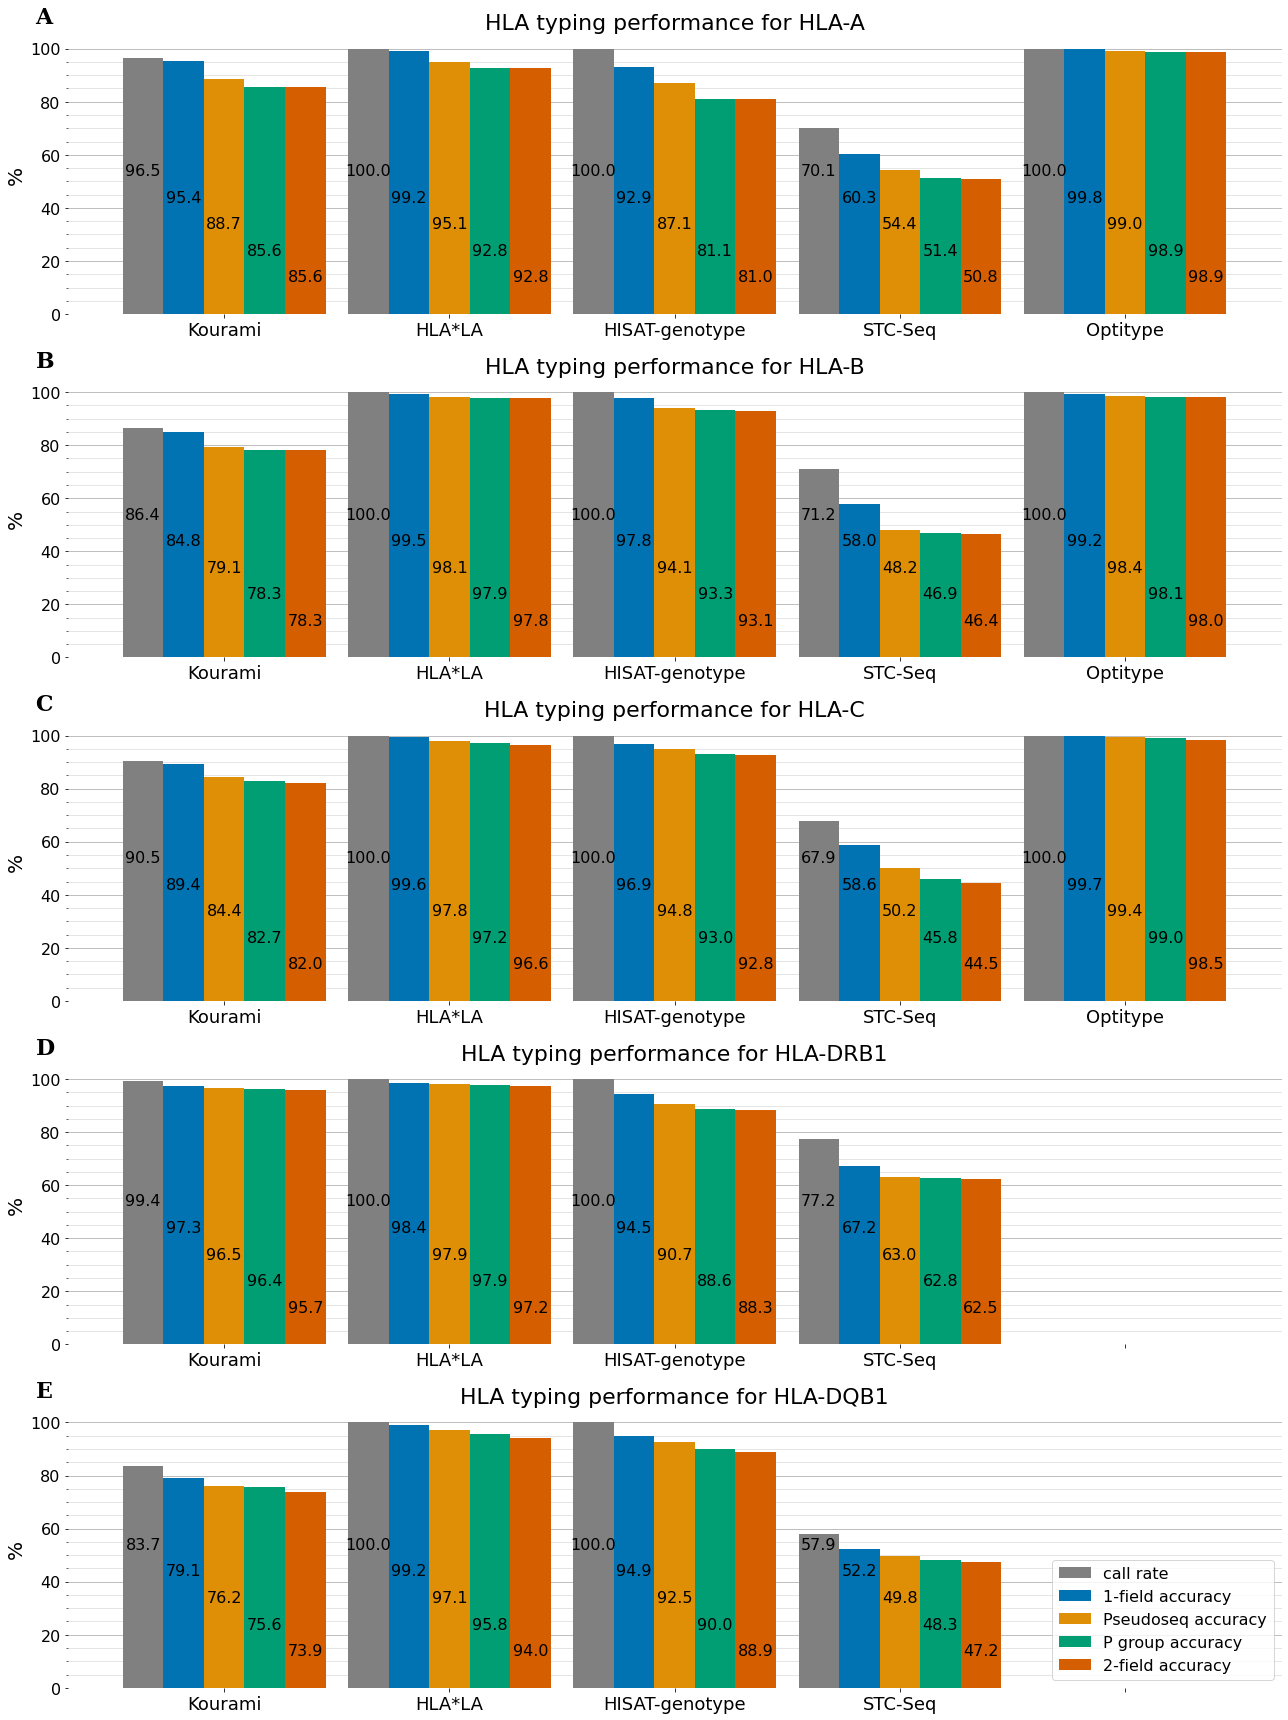

In [9]:
fig = make_plot_from_allele_list()
fig.savefig('paper_plots/FigureS2.tiff')
fig.savefig('paper_plots/FigureS2.eps')